In [1]:
from climada.util.api_client import Client
from climada.util.constants import RIVER_FLOOD_REGIONS_CSV
from climada_petals.entity.impact_funcs.river_flood import ImpfRiverFlood,flood_imp_func_set
import pandas as pd
from climada.engine import Impact
from climada.hazard import Hazard
import numpy as np
from climada.util import yearsets
import os
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
countries = ['TWN', 'DEU', 'VNM', 'COL', 'USA']

In [3]:
#Define which files are which, would be good to have standardize names
impact_csvs = {}
impact_mats = {}
data_dir = '/Users/szelie/OneDrive - ETH Zurich/20211208_Multi-Impact_ZelieCarmen'
for country in countries:
    impact_csvs[country] = {}
    impact_mats[country] = {}
    impact_csvs[country]['RF'] = os.path.join(data_dir, "".join(['/Users/szelie/OneDrive - ETH Zurich/20211208_Multi-Impact_ZelieCarmen/river_flood_impact_150arcsec_historical_1980_2000_',country,'.csv']))
    impact_mats[country]['RF'] = os.path.join(data_dir, "".join(['/Users/szelie/OneDrive - ETH Zurich/20211208_Multi-Impact_ZelieCarmen/river_flood_impact_150arcsec_historical_1980_2000_',country,'.npz']))


    impact_csvs[country]['TC']  = os.path.join(data_dir, "".join(['TC_impact_mat/imp_',country,'.csv']))
    impact_mats[country]['TC']= os.path.join(data_dir, "".join(['TC_impact_mat/imp_mat_',country,'.npz']))
   
    impact_csvs[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/imp_WF_',country,'.csv']))
    impact_mats[country]['WF'] = os.path.join(data_dir, "".join(['WF_impact/imp_mat_WF_',country,'.npz']))
    

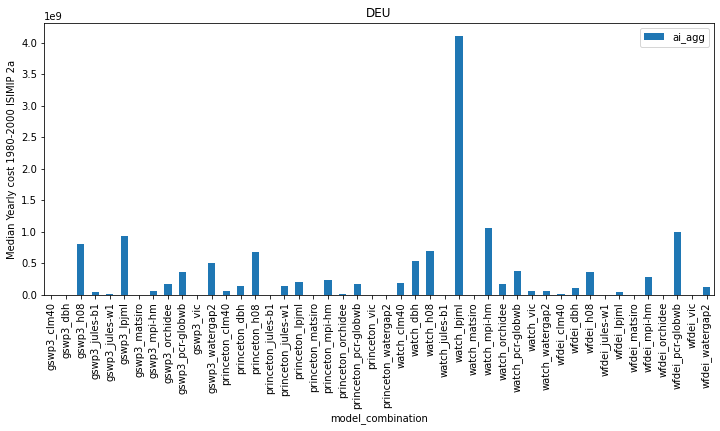

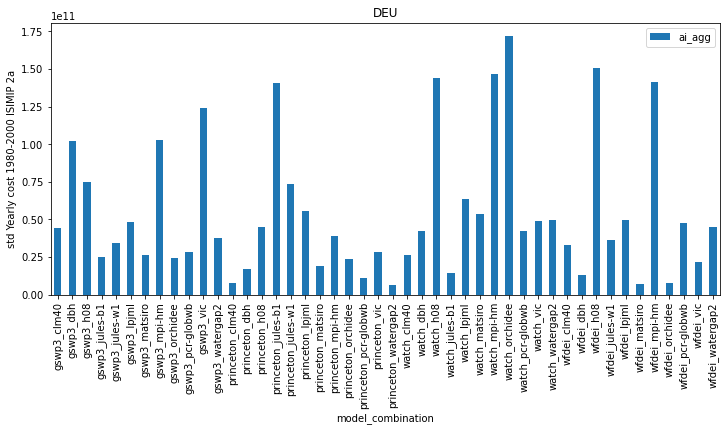

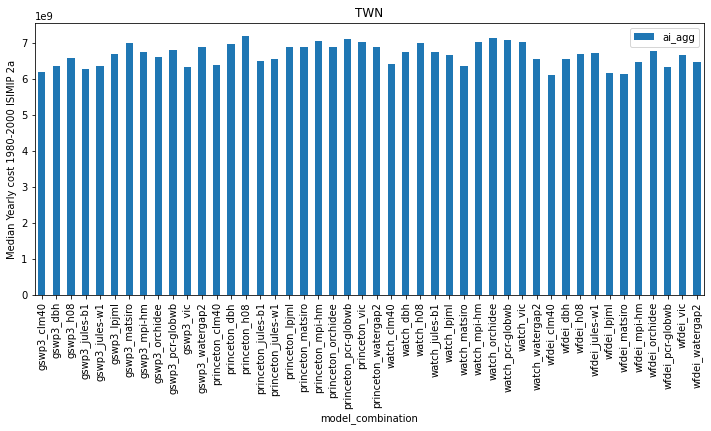

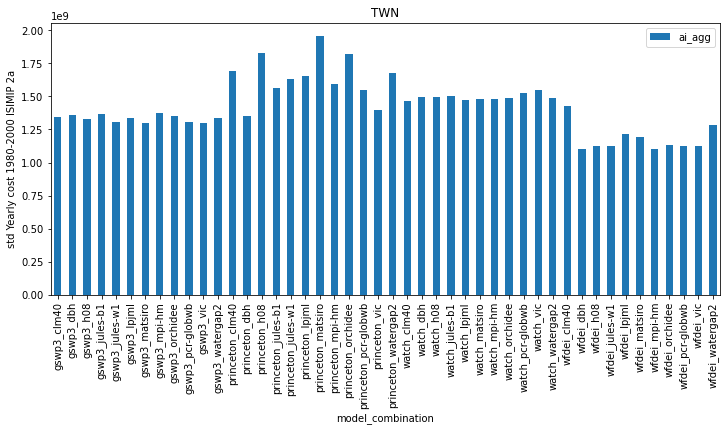

In [4]:
#Do the number for floods make sense?
# better check percentiles than std

plt.rcParams["figure.figsize"] = (12,5)

countries = ['DEU', 'TWN']
for country in countries:
    impact = Impact.from_csv(impact_csvs[country]['RF'])
    impact.imp_mat = impact.read_sparse_csr(impact_mats[country]['RF'])
    df = pd.DataFrame({'ai_agg': impact.at_event, 'event_name':impact.event_name})
    df = df['event_name'].str.split('_', expand=True).join(df)
    df = df.rename(columns={0:'year', 1:'hydro_model', 2:'climate_model'})
    #df['ai_agg'][df['ai_agg'] > 1e11] = np.nan
    df_median = df.groupby(['climate_model', 'hydro_model']).median().reset_index()
    df_std = df.groupby(['climate_model', 'hydro_model']).std().reset_index()


    df_median["model_combination"] = df_median["climate_model"] +'_'+ df_median["hydro_model"]
    df_std["model_combination"] = df_std["climate_model"] +'_'+ df_std["hydro_model"]


    df_median.plot.bar('model_combination', 'ai_agg', title=country)
    plt.ylabel("Median Yearly cost 1980-2000 ISIMIP 2a")
    
    
    df_std.plot.bar('model_combination', 'ai_agg', title=country)
    plt.ylabel("std Yearly cost 1980-2000 ISIMIP 2a")
    #plt.ylabel("Y axis label")


In [5]:
#sample events per year
def sample_events(impact, lam=1, years = np.array(range(1980,2000))):
    #create sampling vector
    events_per_year = yearsets.sample_from_poisson(len(years), lam)
    sampling_vect = yearsets.sample_events(events_per_year, impact.frequency)
    impact_sample = yearsets.impact_from_sample(impact, years, sampling_vect)
    return impact_sample 

def make_yearset_country(country, csv, impact_mat, n_samples=20, years=np.array(range(1980,2000))):
    try:
        impact = Impact.from_csv(csv)
        impact.imp_mat = impact.read_sparse_csr(impact_mat)
    except:
        print("".join([" No data for ", str(country)]))
        return([])
    lam = np.sum(impact.frequency)
    lam = np.round(lam, 10)
    yearset_list = [sample_events(impact, lam=lam) for n in range(n_samples)]
    if yearset_list[0].imp_mat.shape[0]>len(years):
        client =Client()
        exposures = client.get_litpop_default(country)
        yearset_list = [yearsets.aggregate_impact_to_year(yearset, exp=exposures) for yearset in yearset_list]
        
    return(yearset_list)
    

In [6]:
impacts_yearsets = {country:{hazard: make_yearset_country(country, impact_csvs[country][hazard], 
                                                  impact_mats[country][hazard]) for hazard in impact_csvs[country]} for country in impact_csvs}

/Users/szelie/miniconda3/envs/climada_env/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


 No data for VNM
 No data for COL


/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_8311/1843293761.py:11: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types.Specify dtype option on import or set low_memory=False.
  impact = Impact.from_csv(csv)


 No data for USA


In [7]:
impacts_yearsets

{'TWN': {'RF': [<climada.engine.impact.Impact at 0x7fa1304a60a0>,
  'TC': [<climada.engine.impact.Impact at 0x7fa147dec5e0>,
  'WF': [<climada.engine.impact.Impact at 0x7fa15152e160>,
   <climada.engine.impact.Impact at 0x7fa1515cdb50>]},
 'DEU': {'RF': [<climada.engine.impact.Impact at 0x7fa16035b250>,
  'TC': [<climada.engine.impact.Impact at 0x7fa0e2d750a0>,
  'WF': [<climada.engine.impact.Impact at 0x7fa1506b8a60>,
   <climada.engine.impact.Impact at 0x7fa160225940>]},
 'VNM': {'RF': [<climada.engine.impact.Impact at 0x7fa160225c10>,
  'TC': [<climada.engine.impact.Impact at 0x7fa150697d30>,
  'WF': []},
 'COL': {'RF': [<climada.engine.impact.Impact at 0x7fa1469d4040>,
  'TC': [<climada.engine.impact.Impact at 0x7fa14731dfd0>,
  'WF': []},
 'USA': {'RF': [<climada.engine.impact.Impact at 0x7fa0e1eff280>,
  'TC': [<climada.engine.impact.Impact at 0x7fa1602252b0>,
  'WF': []}}

In [8]:
#get impact for each year
def aai_dist(impacts_yearsets):
    if len(impacts_yearsets)>0:
        annual_impact_list = np.concatenate([impact.at_event for impact in impacts_yearsets])
        return annual_impact_list
    else:
        return [np.nan]   

    
## 300 year worst year event
def max_ai(impacts_yearsets):
    return(np.quantile(aai_dist(impacts_yearsets), 0.95))
 
def median_ai(impacts_yearsets):
    return(np.median(aai_dist(impacts_yearsets)))    

def mean_ai(impacts_yearsets):
    return(np.mean(aai_dist(impacts_yearsets)))    

In [9]:
max_cost_dict = {country: {hazard: max_ai(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}

median_cost_dict = {country: {hazard: median_ai(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}


mean_cost_dict = {country: {hazard: mean_ai(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}



In [10]:
max_cost_dict['DEU']['RF']/1e9 #super high

107.38786275481043

In [11]:
annual_impact_list = {country: {hazard: aai_dist(impacts_yearsets[country][hazard]) for hazard in impacts_yearsets[country]} for country in impacts_yearsets}


In [12]:
np.median(annual_impact_list['TWN']['RF'])

6808278607.269999

In [13]:
aai_dist_array = aai_dist(impacts_yearsets['DEU']['RF'])

(array([364.,  14.,   4.,  14.,   3.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00000000e+00, 5.12698719e+10, 1.02539744e+11, 1.53809616e+11,
        2.05079488e+11, 2.56349360e+11, 3.07619232e+11, 3.58889103e+11,
        4.10158975e+11, 4.61428847e+11, 5.12698719e+11]),
 <BarContainer object of 10 artists>)

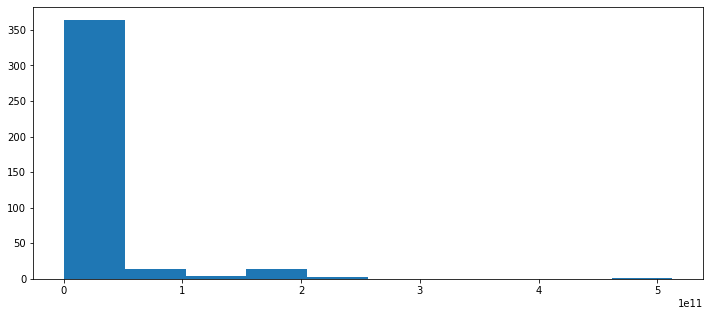

In [14]:
plt.hist(annual_impact_list['DEU']['RF'])

(array([ 86.,  59.,  59., 102.,  49.,  17.,  18.,   7.,   2.,   1.]),
 array([4.65901210e+09, 5.38739166e+09, 6.11577123e+09, 6.84415079e+09,
        7.57253035e+09, 8.30090991e+09, 9.02928948e+09, 9.75766904e+09,
        1.04860486e+10, 1.12144282e+10, 1.19428077e+10]),
 <BarContainer object of 10 artists>)

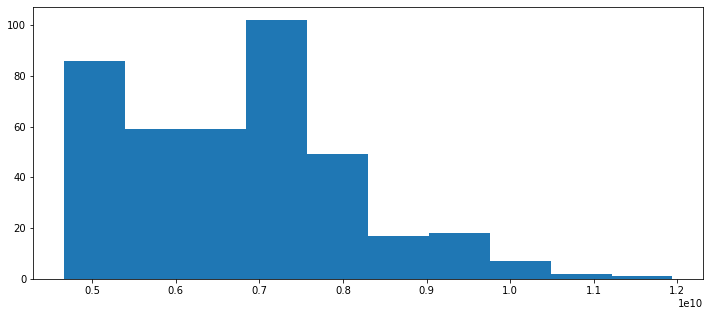

In [15]:
plt.hist(annual_impact_list['TWN']['RF'])

In [16]:
natcat = pd.read_csv(os.path.join(data_dir, 'natcat_damage.csv'))
for country in mean_cost_dict:
    median_cost_dict[country]['rf_natcat'] = np.float(natcat[natcat.ISO==country]['flood_damage_adj_inf'])
    median_cost_dict[country]['tc_natcat'] = np.float(natcat[natcat.ISO==country]['tc_damage_adj_inf'])
    

/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_8311/93794206.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  median_cost_dict[country]['rf_natcat'] = np.float(natcat[natcat.ISO==country]['flood_damage_adj_inf'])
/var/folders/f5/lms0b90j1kx7kk4v552qkjqw0000gp/T/ipykernel_8311/93794206.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#de

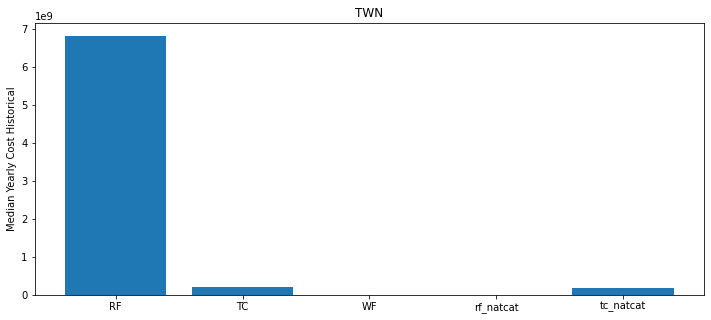

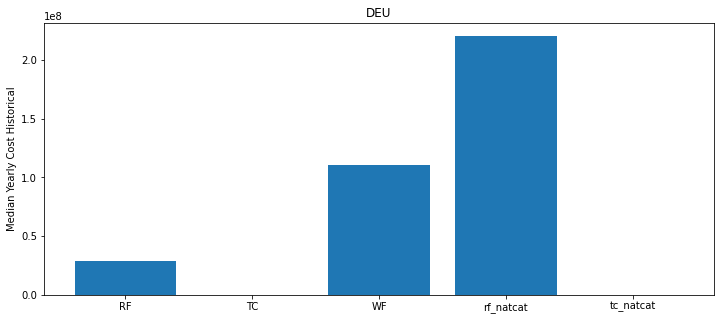

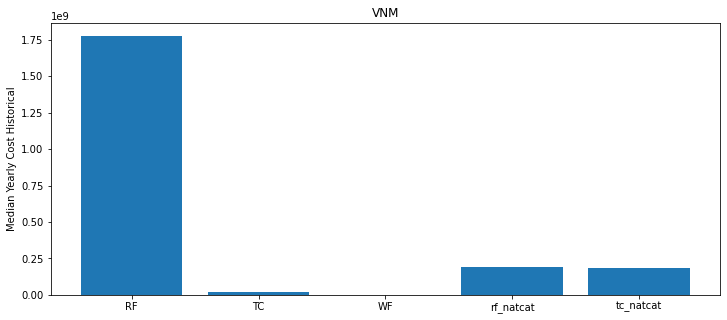

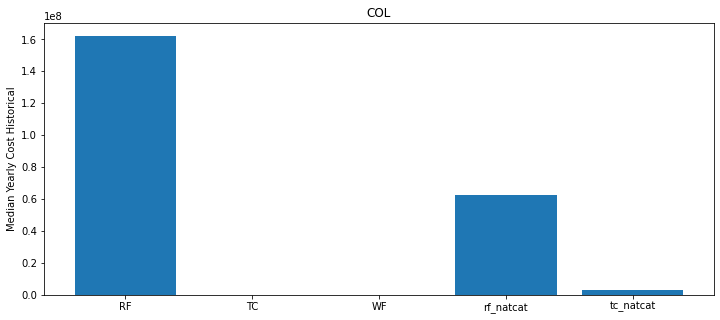

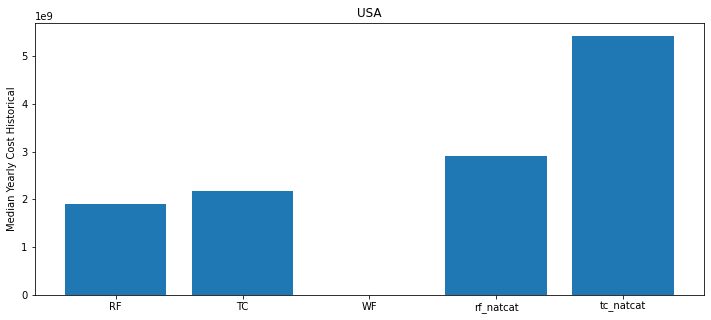

In [17]:
for country in median_cost_dict:
    fig, ax = plt.subplots()
    ax.bar(median_cost_dict[country].keys(), median_cost_dict[country].values())
    ax.set_ylabel('Median Yearly Cost Historical')
    ax.set_title(country)

In [18]:
median_cost_dict[country]

{'RF': 1895212627.5964968,
 'TC': 2176110262.4847093,
 'WF': nan,
 'rf_natcat': 2902105372.253208,
 'tc_natcat': 5417002704.329529}